# Topological Data Analysis of Stock Market Indices in Python

In this notebook I follow the analysis outlined by Marian Gidea and Yuri Katz in their paper *Topological Data Analysis of Financial Time Series: Landscapes of Crashes* [[1]](#gidea_topological_2018)

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf

# my library functions
import lib

# graphing
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

# giotto-tda library tools
from gtda.homology import VietorisRipsPersistence
from gtda.time_series import SlidingWindow
from gtda.plotting import plot_point_cloud, plot_diagram
from gtda.diagrams import Amplitude, PersistenceLandscape

# Miscellany
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.stattools import acf

# Parallelism
from dask.distributed import Client
import dask.dataframe as dd
import dask.array as da

In [2]:
client = Client(n_workers=16, threads_per_worker=4)
client

<Client: 'tcp://127.0.0.1:41859' processes=16 threads=64, memory=15.04 GiB>

In [3]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "^GSPC ^DJI ^IXIC ^RUT ^VIX",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "max",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",
    
        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        #group_by = 'ticker',

        # use threads for mass downloading? (True/False/Integer)
        # (optional, default is True)
        threads = True
    )

[*********************100%%**********************]  5 of 5 completed


In [4]:
# drop any dates for which we don't have complete data
data.dropna(inplace = True)
vol_df = pd.DataFrame(data['Adj Close']['^VIX'])

# Get adjusted closing prices
adj_closes = data['Adj Close'].drop(columns=['^VIX'])
adj_closes

^DJI        ^GSPC         ^IXIC         ^RUT
Date                                                            
1992-01-02   3172.399902   417.260010    586.450012   188.750000
1992-01-03   3201.500000   419.339996    592.650024   192.089996
1992-01-06   3200.100098   417.959991    597.900024   194.330002
1992-01-07   3204.800049   417.399994    602.289978   195.770004
1992-01-08   3203.899902   418.100006    610.320007   198.080002
...                  ...          ...           ...          ...
2023-08-25  34346.898438  4405.709961  13590.650391  1853.630005
2023-08-28  34559.980469  4433.310059  13705.129883  1869.010010
2023-08-29  34852.671875  4497.629883  13943.759766  1895.540039
2023-08-30  34890.238281  4514.870117  14019.309570  1903.209961
2023-08-31  34997.199219  4528.229980  14092.115234  1911.876465

[7976 rows x 4 columns]

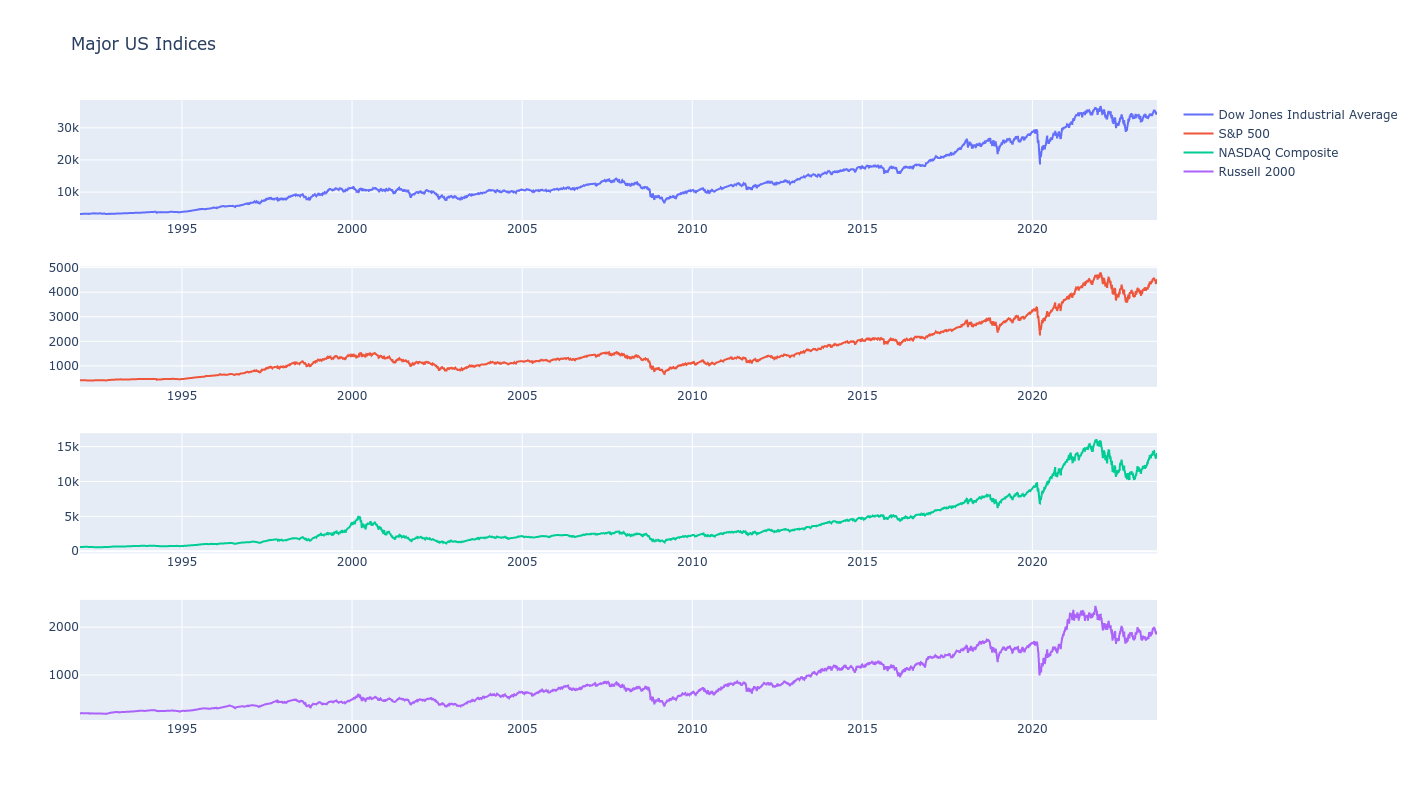

In [36]:
fig = make_subplots(rows=4, cols=1)

# Add traces
fig.append_trace(
    go.Scatter(x=adj_closes.index, y=adj_closes['^DJI'], name='Dow Jones Industrial Average'),
    row=1, col=1
)
fig.append_trace(
    go.Scatter(x=adj_closes.index, y=adj_closes['^GSPC'], name='S&P 500'),
    row=2, col=1
)
fig.append_trace(
    go.Scatter(x=adj_closes.index, y=adj_closes['^IXIC'], name='NASDAQ Composite'),
    row=3, col=1
)
fig.append_trace(
    go.Scatter(x=adj_closes.index, y=adj_closes['^RUT'], name='Russell 2000'),
    row=4, col=1
)
fig.update_layout(height=800, width=960, title_text="Major US Indices")
fig.show()

In [6]:
log_returns = lib.calc_logreturns(adj_closes)
log_returns.tail()

^DJI     ^GSPC     ^IXIC      ^RUT
Date                                              
2023-08-25  0.007231  0.006696  0.009365  0.003973
2023-08-28  0.006185  0.006245  0.008388  0.008263
2023-08-29  0.008433  0.014404  0.017262  0.014095
2023-08-30  0.001077  0.003826  0.005404  0.004038
2023-08-31  0.003061  0.002955  0.005180  0.004543

Now we need to set a window size *w*, defining a point cloud of *w* points at each time *t*.

In [7]:
# cast to an n x 4 matrix
data = log_returns.to_numpy()
w = 50

In [8]:
# Giotto-tda has a Sliding Window class but I decided to use ndarray indexing to roll my own
point_clouds = lib.sliding_window(log_returns, w)
point_clouds.shape

(7926, 50, 4)

In [9]:
# Using the class provided by giotto-tda
windows = SlidingWindow(size=w)
point_clouds2 = windows.fit_transform(log_returns)

# This should be true if both methods produce the same ndarray
assert(np.equal(point_clouds, point_clouds2).all())


Now that we've constructed our 4-dimensional point clouds, let's use PCA to do some dimension reduction and get a rough idea of what one of them looks like.


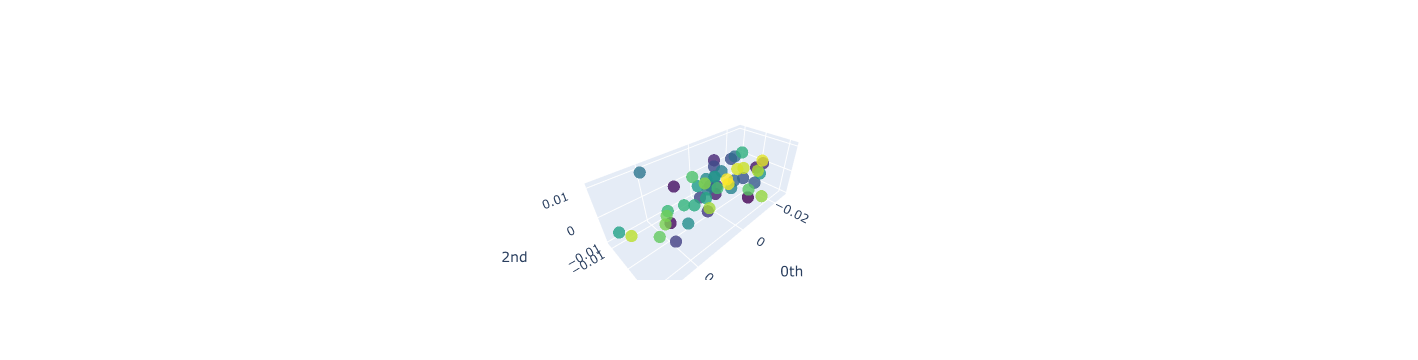

In [10]:
i = point_clouds.shape[0] - 1
pca = PCA(n_components=3)
point_cloud_pca = pca.fit_transform(point_clouds[i])
plot_point_cloud(point_cloud_pca)

Now comes one of the central ideas of topological data analysis.  We use a filtration of Vietoris-Rips complexes to calculate the (1-dimensional) persistent homology of our point clouds.

In [11]:
VR = VietorisRipsPersistence(homology_dimensions = [1], n_jobs = -1)
diagrams = VR.fit_transform(point_clouds)
diagrams.shape

(7926, 17, 3)

In [12]:
diagrams[i]

array([[0.01124041, 0.01181637, 1.        ],
       [0.00879814, 0.00958184, 1.        ],
       [0.00862636, 0.00864385, 1.        ],
       [0.00756051, 0.01012971, 1.        ],
       [0.00751145, 0.009781  , 1.        ],
       [0.00714425, 0.00879811, 1.        ],
       [0.006689  , 0.00911562, 1.        ],
       [0.00446511, 0.00491264, 1.        ],
       [0.00134559, 0.00134559, 1.        ],
       [0.00134559, 0.00134559, 1.        ],
       [0.00134559, 0.00134559, 1.        ],
       [0.00134559, 0.00134559, 1.        ],
       [0.00134559, 0.00134559, 1.        ],
       [0.00134559, 0.00134559, 1.        ],
       [0.00134559, 0.00134559, 1.        ],
       [0.00134559, 0.00134559, 1.        ],
       [0.00134559, 0.00134559, 1.        ]])

A persistence diagram is a collection of (birth, death) ordered pairs representing the emergence and disappearance of topological features as we increase the allowed distance between connected points (and simplexes) in the Vietoris-Rips complex.  A graphical representation of the above diagram is below.  In this case, since we are looking at the 1-dimensional persistent homology, the topological features we are looking at can be thought of as 1-dimensional holes, i.e. loops.

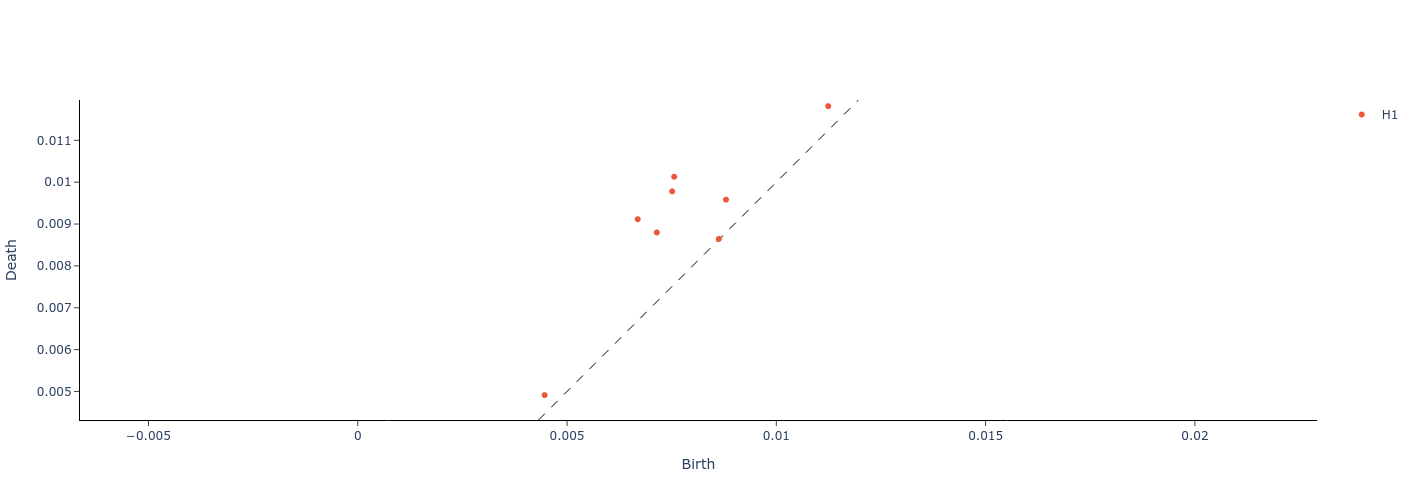

In [13]:
plot_diagram(diagrams[i])

A persistence landscape is a way of transforming a persistence diagram into a form that is easier to work with.  In particular, the norm associated with a persistence landscape exists in a space with "nice" mathematical properties for the purposes of statistics and machine learning (a Banach space).

In [14]:
# We calculate the L1 and L2 norms of the persistence landscapes associated with our diagrams
L1_norms = Amplitude(metric='landscape', metric_params={'p':1}).fit_transform(diagrams)
L2_norms = Amplitude(metric='landscape', metric_params={'p':2}).fit_transform(diagrams)

# Now we normalize
scaler = MinMaxScaler()
L1 = scaler.fit_transform(L1_norms)
L2 = scaler.fit_transform(L2_norms)

# Now we put them in the columns of a dataframe indexed by date
norm_arr = np.hstack((L1, L2))
date_index = log_returns[(w - 1):].index

norm_df = pd.DataFrame(norm_arr, index = date_index, columns=['L1', 'L2'])
norm_df.tail()

L1        L2
Date                          
2023-08-25  0.085781  0.170915
2023-08-28  0.074714  0.155867
2023-08-29  0.084390  0.173413
2023-08-30  0.081234  0.172613
2023-08-31  0.083202  0.169010

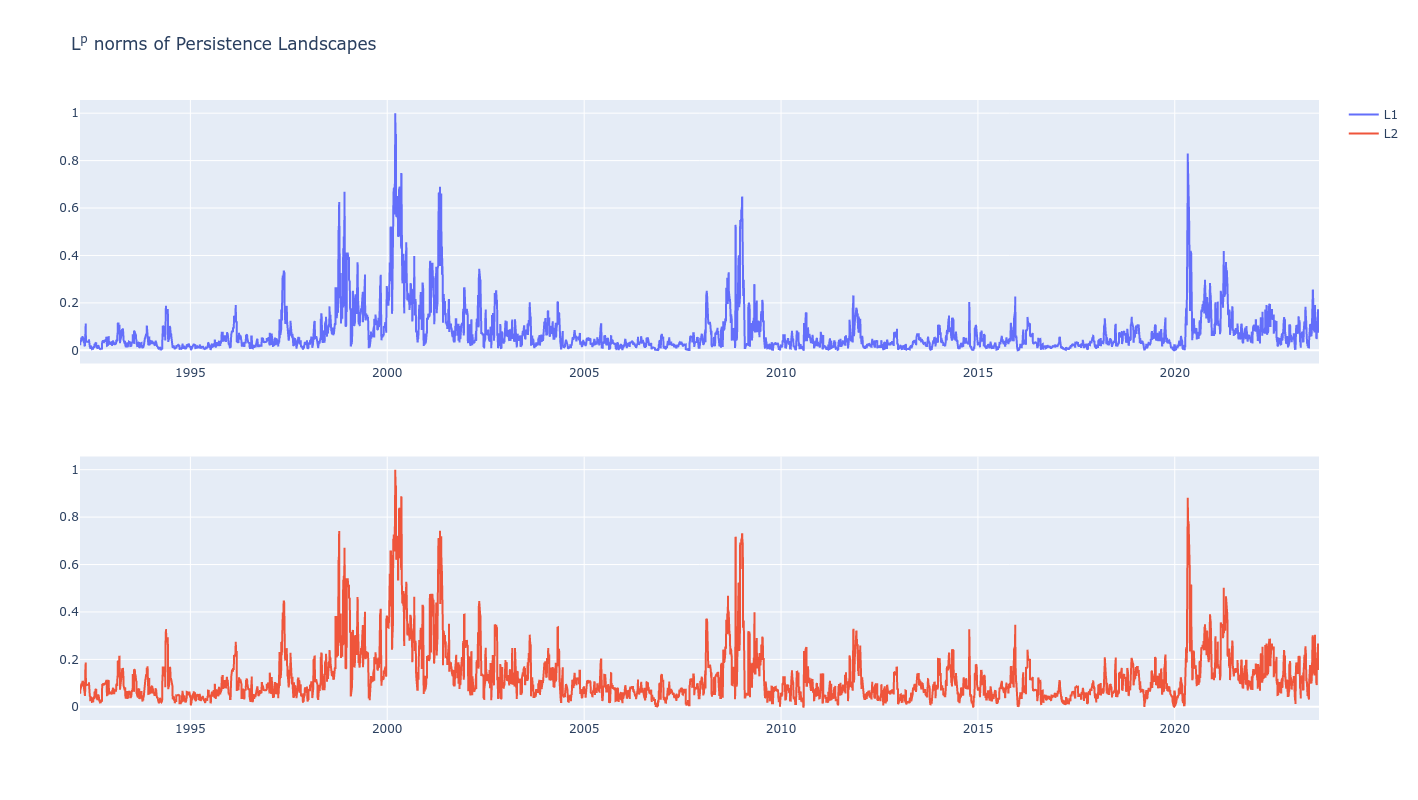

In [15]:
# Finally, we can graph the norms of the persistence landscapes over time
fig = make_subplots(rows=2, cols=1)

# Add traces
fig.add_trace(
    go.Scatter(x=norm_df.index, y=norm_df['L1'], name='L1'),
    row=1, col=1
)
fig.add_trace(
    go.Scatter(x=norm_df.index, y=norm_df['L2'], name='L2'),
    row=2, col=1
)
fig.update_layout(height=800, width=1280, title_text="L<sup>p</sup> norms of Persistence Landscapes")
fig.show()

We can see that the $L^p$ norms spike in March 2000, late 2008 to early 2009, and late April through early May of 2020.  These correspond the the Dot-com bubble, Global Financial Crisis, and COVID-19 Pandemic.  While only the spike leading up to the height of the Dot-com bubble seems to have been early enough to be an effective warning sign, these results are interesting nonetheless, as it shows these norms could be used to measure market volatility in a way that is not directly related to VIX.

In [16]:
period = 250
rolling_w = 500

# Define a window corresponding to the (period + rolling_w - 1) trading days prior to March 10, 2000
# I expanded the window at the beginning so that I can compute metrics 
# on sliding sub-windows starting at the very first observation

# norms_dotcom_expanded = norm_df.loc[:'2000-03-10'][-(period+rolling_w):-1]
# norms_dotcom = norms_dotcom_expanded[rolling_w-1:]

# vol_dotcom = vol_df.loc[:'2000-03-10'][-(period+1):-1]

max_freq = 8/rolling_w

In [17]:
dndf = dd.from_pandas(norm_df, chunksize=rolling_w)
dndf

Dask DataFrame Structure:
                     L1       L2
npartitions=16                  
1992-03-13      float64  float64
1994-03-04          ...      ...
...                 ...      ...
2021-12-21          ...      ...
2023-08-31          ...      ...
Dask Name: from_pandas, 1 graph layer

In [18]:
# f, p = lib.low_pass_pgram(norm_df.loc[:'2000-03-10','L2'], max_freq=0.1, method='welch')
# px.line(x=f, y=p)

In [19]:
%%time
power = dndf.rolling(rolling_w).apply(lambda s: lib.low_pass_pgram(s, max_freq=max_freq, method='welch')[1].mean())
acf1 = dndf.rolling(rolling_w).apply(lambda s: acf(s, nlags=1)[1])

CPU times: user 6.58 ms, sys: 0 ns, total: 6.58 ms
Wall time: 6.48 ms


In [20]:
%%time
power_computed = power.compute()

CPU times: user 546 ms, sys: 137 ms, total: 683 ms
Wall time: 2.67 s


In [21]:
%%time
acf1_computed = acf1.compute()

CPU times: user 284 ms, sys: 43.8 ms, total: 328 ms
Wall time: 844 ms


In [22]:
spec_index = norm_df.index[(rolling_w - 1):]

In [23]:
# This should be true if spec_index is in fact the index of all rows with a computed power spectrum
norm_df[power_computed.notna().all(axis=1)].index.equals(spec_index)

True

In [24]:
# This should be true if the ACF(1) exists when the power spectrum does
norm_df[acf1_computed.notna().all(axis=1)].index.equals(spec_index)

True

In [25]:
df = vol_df.join(norm_df, validate="one_to_one")
df.columns = pd.MultiIndex.from_product([df.columns, ['Value']])

# Define a window corresponding to the period length number of trading days prior to March 10, 2000
dotcom_index = df.loc[:'2000-03-10'][-(period+1):-1].index

In [26]:
df.loc[spec_index, ('L1', 'Spectrum')] = power_computed.loc[spec_index,'L1']
df.loc[spec_index, ('L2', 'Spectrum')] = power_computed.loc[spec_index,'L2']
df.loc[spec_index, ('L1', 'ACF(1)')] = acf1_computed.loc[spec_index,'L1']
df.loc[spec_index, ('L2', 'ACF(1)')] = acf1_computed.loc[spec_index,'L2']
df.loc[spec_index]

^VIX        L1        L2        L1        L2        L1  \
                Value     Value     Value  Spectrum  Spectrum    ACF(1)   
Date                                                                      
1994-03-03  16.360001  0.015384  0.036970  0.020533  0.071526  0.914722   
1994-03-04  16.000000  0.015296  0.036834  0.020524  0.071580  0.914766   
1994-03-07  14.260000  0.010445  0.028639  0.020494  0.071541  0.915717   
1994-03-08  16.230000  0.007014  0.020556  0.020441  0.071465  0.915648   
1994-03-09  14.410000  0.007014  0.020556  0.020386  0.071370  0.916039   
...               ...       ...       ...       ...       ...       ...   
2023-08-25  15.680000  0.085781  0.170915  0.059307  0.121192  0.871303   
2023-08-28  15.080000  0.074714  0.155867  0.058866  0.120133  0.871285   
2023-08-29  14.450000  0.084390  0.173413  0.058397  0.118988  0.870961   
2023-08-30  13.880000  0.081234  0.172613  0.057894  0.117895  0.871027   
2023-08-31  13.640000  0.083202  0.169010  0.057457  0.116891  0.872156   

                  L2  
              ACF(1)  
Date                  
1994-03-03  0.922484  
1994-03-04  0.922535  
1994-03-07  0.923033  
1994-03-08  0.922744  
1994-03-09  0.923115  
...              ...  
2023-08-25  0.857643  
2023-08-28  0.857684  
2023-08-29  0.857234  
2023-08-30  0.857226  
2023-08-31  0.858932  

[7427 rows x 7 columns]

In [27]:
#L = lib.sliding_window(norm_df, rolling_w)
#np.apply_along_axis(lambda s: np.var(s), 1, L)

In [28]:
df.loc[spec_index].xs('Spectrum', axis=1, level=1)

L1        L2
Date                          
1994-03-03  0.020533  0.071526
1994-03-04  0.020524  0.071580
1994-03-07  0.020494  0.071541
1994-03-08  0.020441  0.071465
1994-03-09  0.020386  0.071370
...              ...       ...
2023-08-25  0.059307  0.121192
2023-08-28  0.058866  0.120133
2023-08-29  0.058397  0.118988
2023-08-30  0.057894  0.117895
2023-08-31  0.057457  0.116891

[7427 rows x 2 columns]

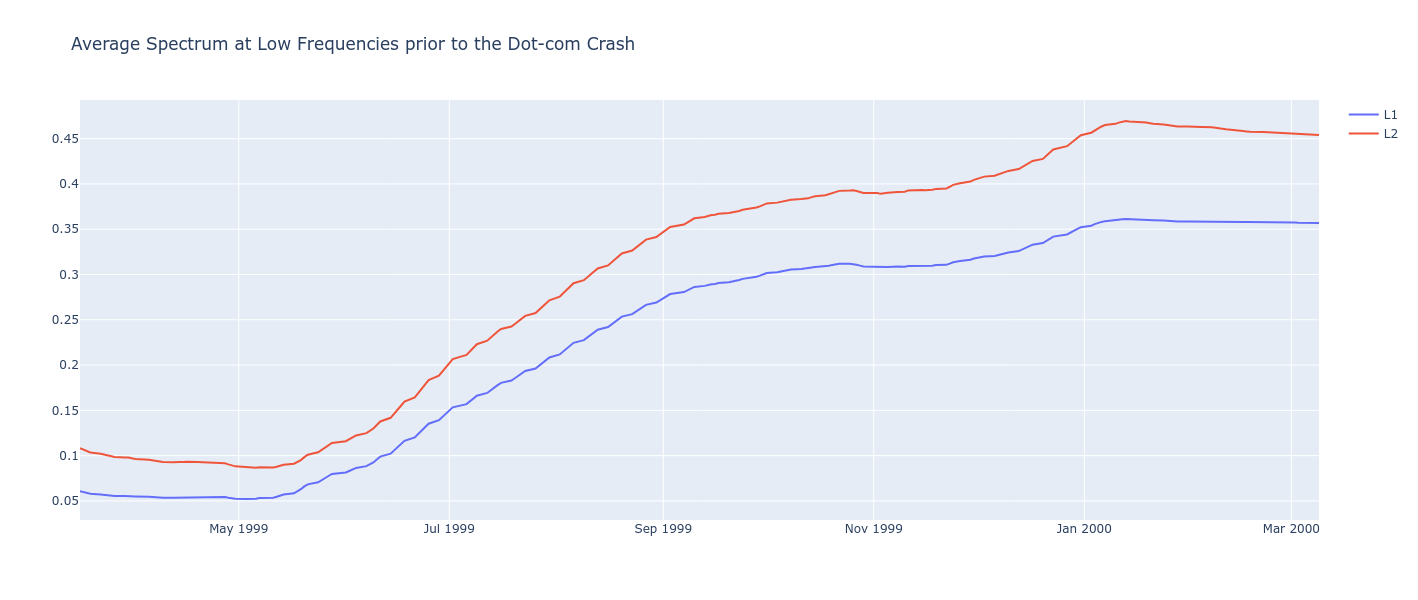

In [29]:
lib.line_charts(df.loc[dotcom_index].xs('Spectrum', axis=1, level=1),
                "Average Spectrum at Low Frequencies prior to the Dot-com Crash", height=600, width=600, subplots=False)

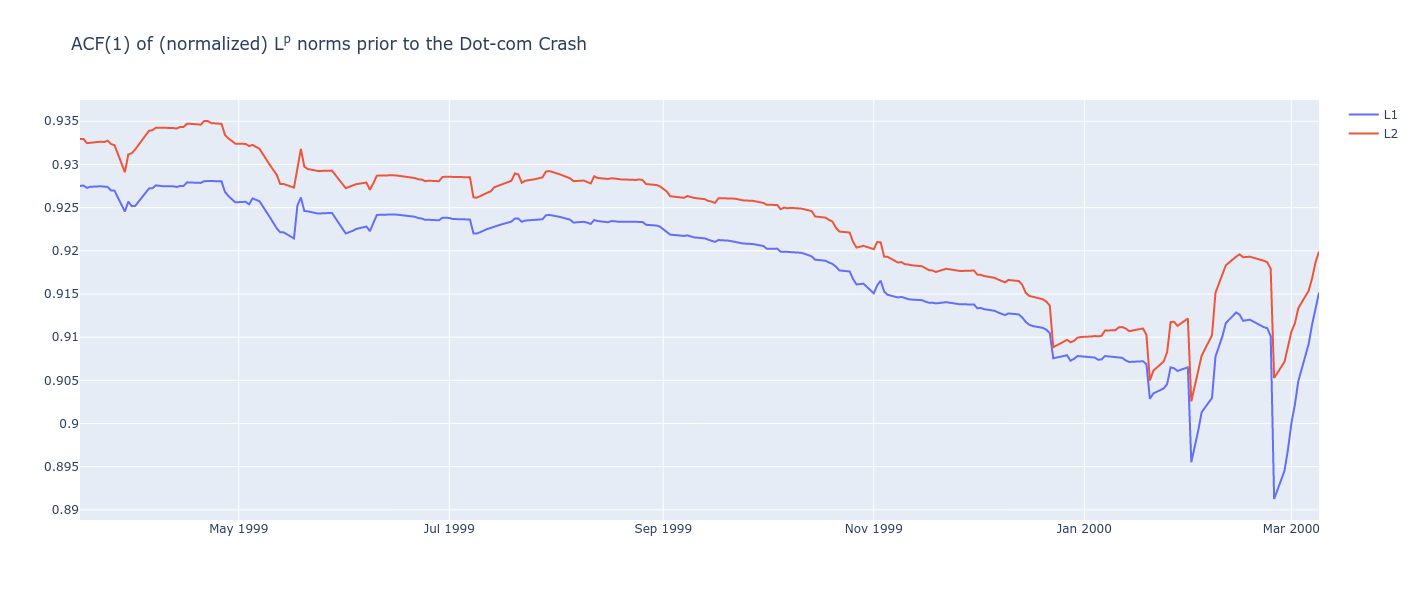

In [30]:
lib.line_charts(df.loc[dotcom_index].xs('ACF(1)', axis=1, level=1),
                "ACF(1) of (normalized) L<sup>p</sup> norms prior to the Dot-com Crash", height=600, width=600, subplots=False)

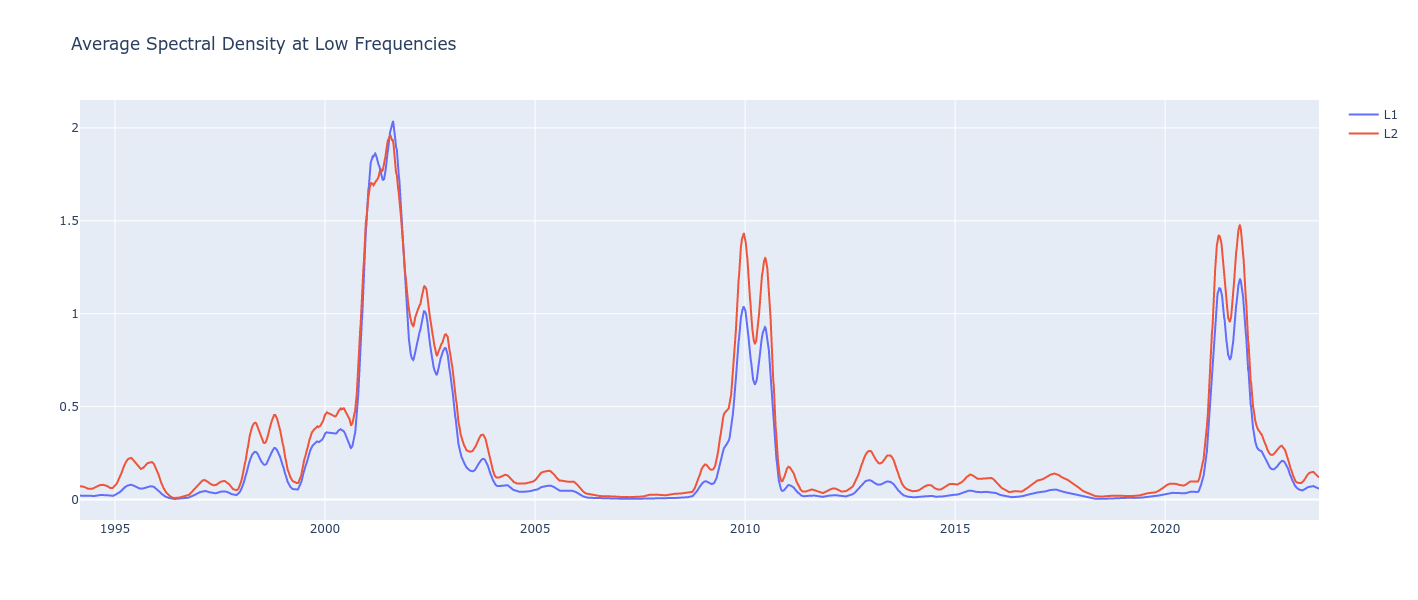

In [31]:
lib.line_charts(df.loc[spec_index].xs('Spectrum', axis=1, level=1),
                "Average Spectral Density at Low Frequencies", height=600, width=1280, subplots=False)

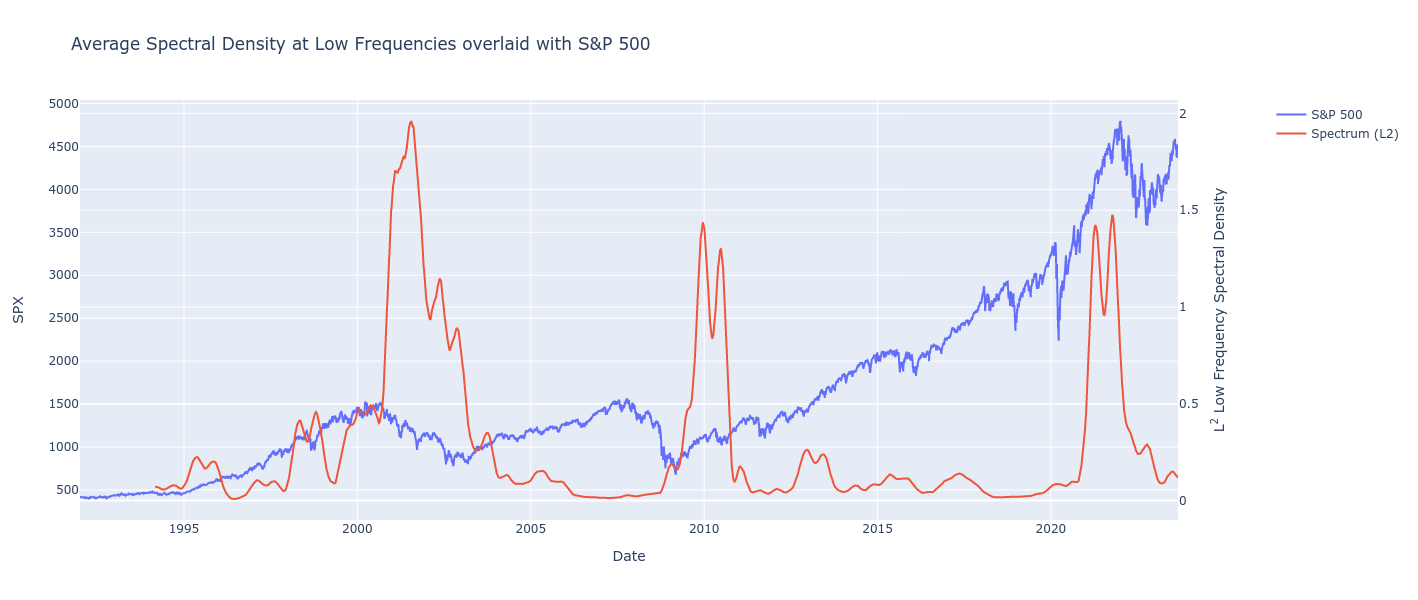

In [46]:
fig = make_subplots(specs=[[{"secondary_y": True}]])

fig.add_trace(
    go.Scatter(x=adj_closes.index, y=adj_closes['^GSPC'], name='S&P 500'),
    secondary_y=False,
)

fig.add_trace(
    go.Scatter(x=spec_index, y=df.loc[spec_index, ('L2', 'Spectrum')], name="Spectrum (L2)"),
    secondary_y=True,
)

fig.update_layout(
    height=600,
    title_text="Average Spectral Density at Low Frequencies overlaid with S&P 500"
)

fig.update_xaxes(title_text="Date")

fig.update_yaxes(title_text="SPX", secondary_y=False)
fig.update_yaxes(title_text="L<sup>2</sup> Low Frequency Spectral Density", secondary_y=True)

fig.show()

## References

<a id='gidea_topological_2018'></a>
[1] M. Gidea and Y. Katz, “Topological Data Analysis of Financial Time Series: Landscapes of Crashes,” Physica A: Statistical Mechanics and its Applications, vol. 491, pp. 820–834, Feb. 2018, doi: [10.1016/j.physa.2017.09.028](https://doi.org/10.1016/j.physa.2017.09.028).